In [ ]:
draft: false
weight: 3
description: Maps and time ryhthms in the San Diego Police calls for service dataset
toc: false
show_input: show
section: notebooks
github: https://github.com/CivicKnowledge/kb.civicknowledge.com/blob/master/notebooks/analysis/San%20Diego%20Police%20Calls%20For%20Service.ipynb

# San Diego Police Calls For Service


Eric Busboom, 7 Nov 2017

In preparation for the [SCALE and Open San Diego Crime ANalysis Presentation](https://www.eventbrite.com/e/exploring-san-diego-crime-data-using-python-workshop-tickets-39192959196?utm_source=eb_email&utm_medium=email&utm_campaign=reminder_attendees_48hour_email&utm_term=eventname), I downloaded the [data package for the presentation](https://drive.google.com/open?id=0B-sBXvhIZi_gWHJENGd2UkhWbVk) and started on the analysis a bit early. 

The presentation will use the San Diego Police 2015 calls for service, but the [data repository has 2016 and 2017 as well](https://data.sandiego.gov/datasets/police-calls-for-service/). The seperate files for each of the three years are converted into a data package on our repository, and I also created Metapack packages for the boundary files for beats, neighborhoods and districts. Merging in these boundary files allows for analysing crime counts by geography. Here are the packages: 

* [SD Police Calls For Service](http://data.sandiegodata.org/dataset/sandiego-gov-police_calls-2015e)
* [SD Police Beat, District Regions](http://data.sandiegodata.org/dataset/sandiego-gov-police_regions)
 
This notebook requires the metapack package for downloading URLS, which you should be able to install, on Python 3.5 or later, with ``pip install metapack``


In [1]:
%matplotlib inline
import metapack as mp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd 

The Metapack system allows for packaging data, long with all of the metadata, and the ``open_package`` function can be used to load packages off the web. The the URL below is to a CSV package, which just referrs to CSV files on the web. You can get the link by to the CSV package file from the resource for ``sandiego.gov-police_regions-1`` in the [SRDRL data library repository page for the package](http://data.sandiegodata.org/dataset/sandiego-gov-police_regions)

In [2]:
regions = mp.open_package('http://library.metatab.org/sandiego.gov-police_regions-1.csv')
regions

After opening packages, we can ask the package for what resources it has, download those resources, and turn them into Pandas dataframes.

In [3]:
calls_p = mp.open_package('http://library.metatab.org/sandiego.gov-police_calls-2015e-1.csv')
calls_p

In [4]:
calls_r = calls_p.resource('pd_calls')
calls_r

Header,Type,Description
incident_num,text,Unique Incident Identifier
date_time,datetime,Date / Time in 24 Hour Format
day,integer,Day of the week
stno,integer,"Street Number of Incident, Abstracted to block level"
stdir1,text,Direction of street in address
street,text,Name of Street
streettype,text,Street Type
stdir2,text,"If intersecting street available, direction of that street"
stname2,text,"If intersecting street available, street name"
sttype2,text,"If intersecting street available, street type"


In [5]:
call_type_r = calls_p.resource('call_type')
call_types = call_type_r.dataframe().rename(columns={'description':'call_type_desc'})
call_types.head()

,call_type,call_type_desc
0,10,"OUT OF SERV, SUBJTOCALL"
1,10-97,ARRIVE ON SCENE
2,1016,PRISONER IN CUSTODY
3,1016PT,PTU (PRISONER TRANSPORT)
4,1016QC,SHOPLIFTER/QUICK CITE


In [6]:
regions_r = regions.resource('pd_beats')
regions_r

Header,Type,Description
id,integer,
objectid,integer,
beat,integer,
div,integer,
serv,integer,
name,text,
geometry,geometry,


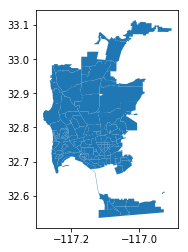

In [7]:
# The beats.cx[:-116.8,:] bit indexes the bounding box to exclude the empty portion of the 
# county. San Diego owns the footprint of a dam in east county, which displays as a tiny
# dot in the middle of empty space. 
# Note that this isn't actually defininf the bounding box; it's cutting out far-east regions, 
# and then GeoPandas creates the smaller bounding box that excludes them. So, the actually 
# value in the cx indexder can vary a bit. 

# Converting to float makes merging with the calls df ewasier, since the beat column
# in that df has nans. 

beats = regions_r.dataframe().geo
beats['beat'] = beats.beat.astype(float)
beats = beats.set_index('beat').cx[:-116.55,:]
beats.plot();

There are a lot of interesting patterns in crime data when you create heat maps of two time dimensions, a visualization called a "Rhythm Map". We'll add the time dimensions now for use later. 

In [8]:
pd_calls = calls_r.read_csv(low_memory=False)

def augment_time(df):
    df['date_time'] = pd.to_datetime(df.date_time)
    
    df['hour'] = df.date_time.dt.hour
    df['month'] = df.date_time.dt.month
    df['year'] = df.date_time.dt.year
    df['dayofweek'] = df.date_time.dt.dayofweek
    df['weekofyear'] = df.date_time.dt.weekofyear

    df['weekofdata'] = (df.year-df.year.min())*52+df.date_time.dt.weekofyear
    df['monthofdata'] = (df.year-df.year.min())*12+df.date_time.dt.month

    return df

assert pd_calls.call_type.dtype == call_types.call_type.dtype

pd_calls = augment_time(pd_calls).merge(call_types, on='call_type')

pd_calls['beat'] = pd_calls.beat.astype(float)

pd_calls = pd_calls.merge(beats.reset_index()[['beat', 'name']], on='beat')\
    .rename(columns={'name':'beat_name'})


# Incident Count Maps

The following maps plot the counts of incidents, over the whole dataset, for different call types, per beat. As is familiar to anyone who has worked with San Diego area crime data, the host spots for most incident types are Pacific Beach and Downtown. 

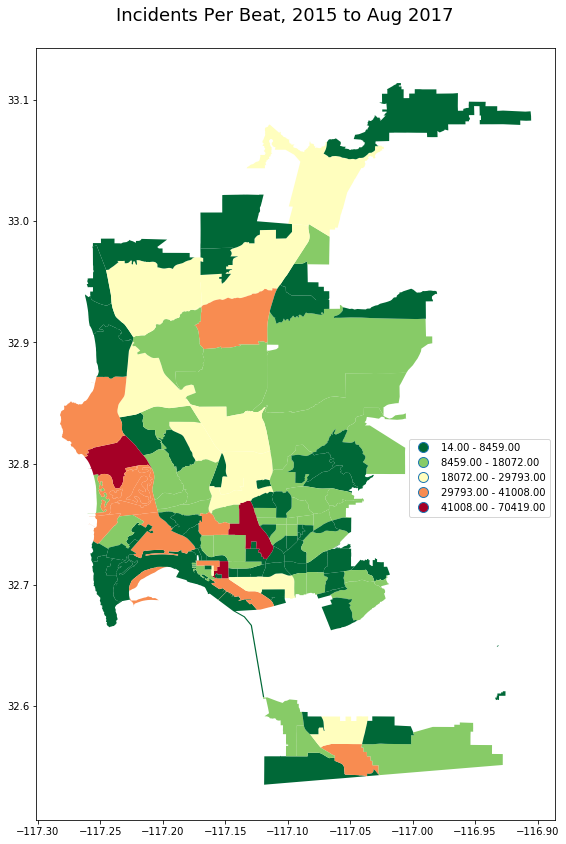

In [9]:

def plot_geo(df, color_col, title=None):
    # Need to get aspect right or it looks wacky
    bb = beats.total_bounds
    aspect = (bb[3] - bb[1])/ (bb[2]-bb[0])
    x_dim = 8

    fig = plt.figure(figsize = (x_dim,x_dim*aspect))
    ax = fig.add_subplot(111)

    df.plot(ax=ax,column=color_col, cmap='RdYlGn_r',
                     scheme='fisher_jenks', legend=True);
  
    if title:
        fig.suptitle(title, fontsize=18);

    leg = ax.get_legend()
   
    #leg.set_bbox_to_anchor((0., 1.02, 1., .102))
    leg.set_bbox_to_anchor((1,.5))

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        
_ = gpd.GeoDataFrame(pd_calls.groupby('beat').incident_num.count().to_frame()\
                               .join(beats))

plot_geo(_, 'incident_num', 'Incidents Per Beat, 2015 to Aug 2017')

In [10]:
pd_calls.call_type_desc.value_counts().iloc[10:30]

FLAG DOWN/FIELD INITIATED         28280
REQUEST FOR TOW TRUCK             27274
NO DETAIL ACCIDENT                27070
MENTAL CASE                       25779
SPECIAL DETAIL                    25115
SELECTIVE ENFORCEMENT             25098
FOLLOW-UP BY FIELD UNIT           24348
HAZARDOUS CONDITION               23954
SLEEPER                           21584
INFORMATION FOR DISPATCHERS       21490
TRAFFIC STOP,FOR TMPOUT           19084
ALL UNITS INFORMATION-PRI 2       19056
LOUD PARTY                        17803
CAR THEFT REPORT                  16952
VEH VIOLATING 72HR PARKING RES    16155
BATTERY                           15757
RECKLESS DRIVING-ALL UNITS        15197
CRIME CASE NUMBER REQUEST         15122
FOOT PATROL/FIELD INITIATED       14955
BURGLARY REPORT                   14652
Name: call_type_desc, dtype: int64

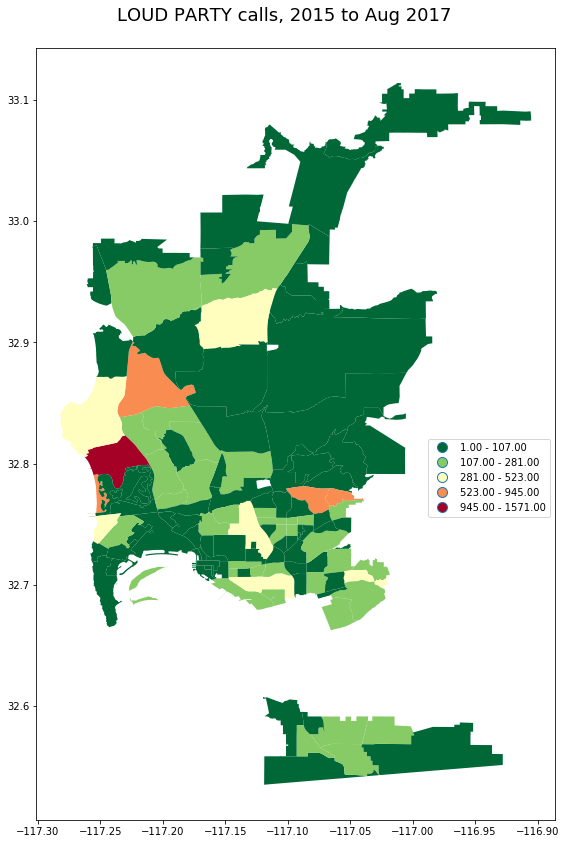

In [11]:
_ = gpd.GeoDataFrame(pd_calls[pd_calls.call_type_desc == 'LOUD PARTY']
                             .groupby('beat')
                             .incident_num.count().to_frame()\
                             .join(beats))

plot_geo(_, 'incident_num', "LOUD PARTY calls, 2015 to Aug 2017")             

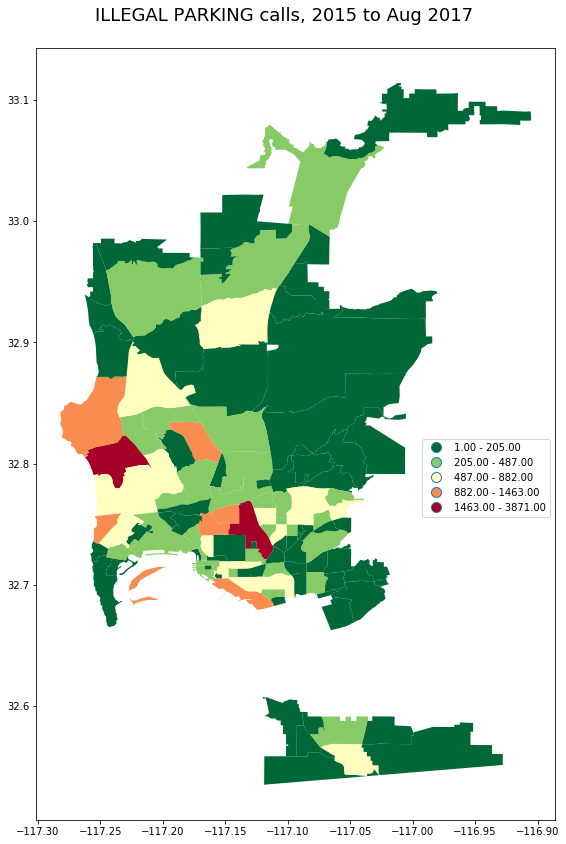

In [12]:
_ = gpd.GeoDataFrame(pd_calls[pd_calls.call_type_desc == 'ILLEGAL PARKING']
                             .groupby('beat')
                             .incident_num.count().to_frame()\
                             .join(beats))

plot_geo(_, 'incident_num',  "ILLEGAL PARKING calls, 2015 to Aug 2017")  

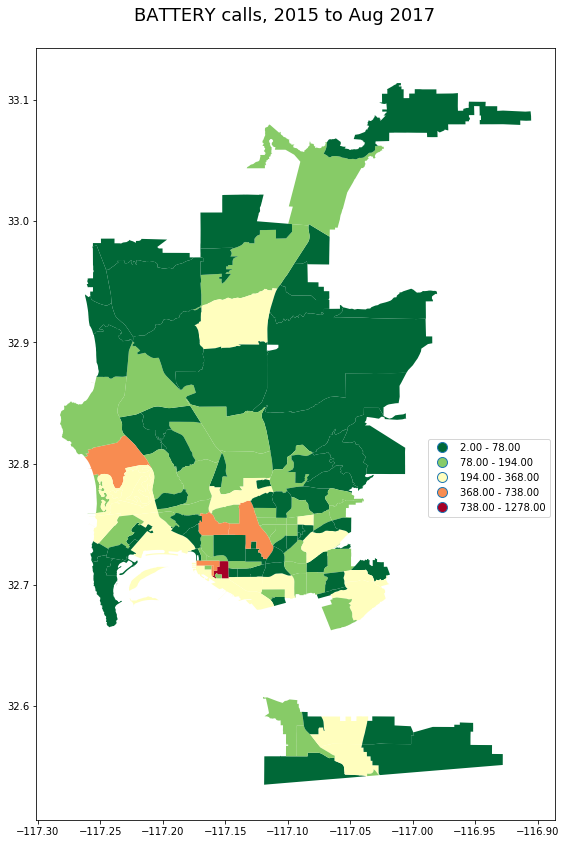

In [13]:
_ = pd_calls[pd_calls.call_type_desc == 'BATTERY']\
                             .groupby('beat')\
                             .incident_num.count().to_frame()\
                             .join(beats)


plot_geo(gpd.GeoDataFrame(_), 'incident_num', "BATTERY calls, 2015 to Aug 2017")  

Sometimes, very high density areas like PB and Downtown will obscure patterns in other areas. One of the ways to handle this is to just exclude those areas. First, let's locate which are the highest crime area. 

In [14]:
_.sort_values('incident_num', ascending=False).head(10)

,incident_num,id,objectid,div,serv,name,geometry
beat,,,,,,,
521.0,1278,98,489,5,520,EAST VILLAGE,POLYGON ((-117.1508808796175 32.71942332829821...
122.0,738,64,231,1,120,PACIFIC BEACH,POLYGON ((-117.2221709033007 32.81525925531844...
524.0,695,93,463,5,520,CORE-COLUMBIA,"POLYGON ((-117.171021304813 32.71987375185346,..."
523.0,654,30,83,5,520,GASLAMP,POLYGON ((-117.1610808948147 32.71569562856276...
627.0,565,83,408,6,620,HILLCREST,POLYGON ((-117.1616090022237 32.75878799862505...
813.0,495,74,352,8,810,NORTH PARK,"POLYGON ((-117.1304627884029 32.7691214134209,..."
512.0,368,58,203,5,510,LOGAN HEIGHTS,POLYGON ((-117.1213484238577 32.70672846114386...
614.0,350,24,64,6,610,OCEAN BEACH,POLYGON ((-117.2340495278368 32.75789474471601...
511.0,348,21,52,5,510,None,(POLYGON ((-117.2252864171211 32.7026041543147...


Here is the map excluding the top 5 high crime areas. The excluded areas are omitted completely, shown in white. 

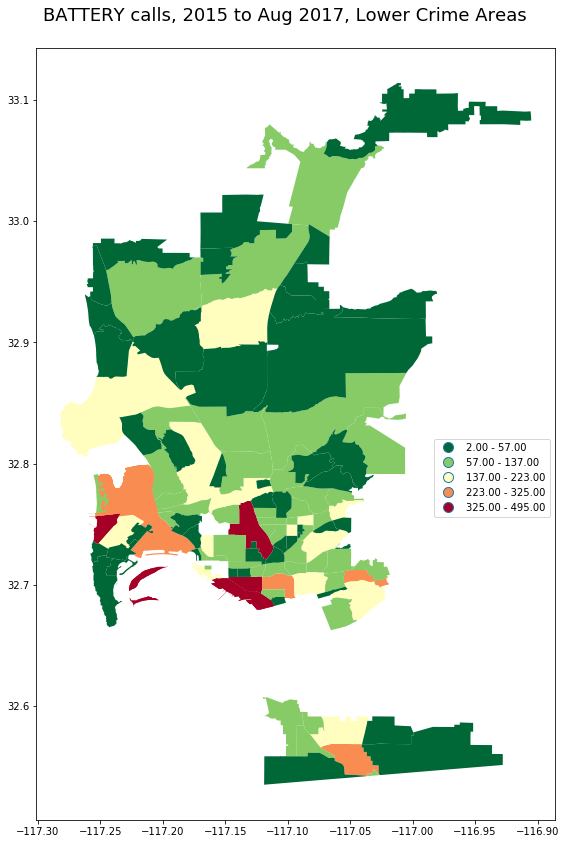

In [15]:
# Could also get the beats by name. 
pb_beat = beats[beats.name=='PACIFIC BEACH'].index.values[0]
gas_beat = beats[beats.name=='GASLAMP'].index.values[0]

low_crime = _.sort_values('incident_num', ascending=False).iloc[5:]
_lc = _.loc[list(low_crime.index.values)]

plot_geo(gpd.GeoDataFrame(_lc), 'incident_num', 
         "BATTERY calls, 2015 to Aug 2017, Lower Crime Areas")  

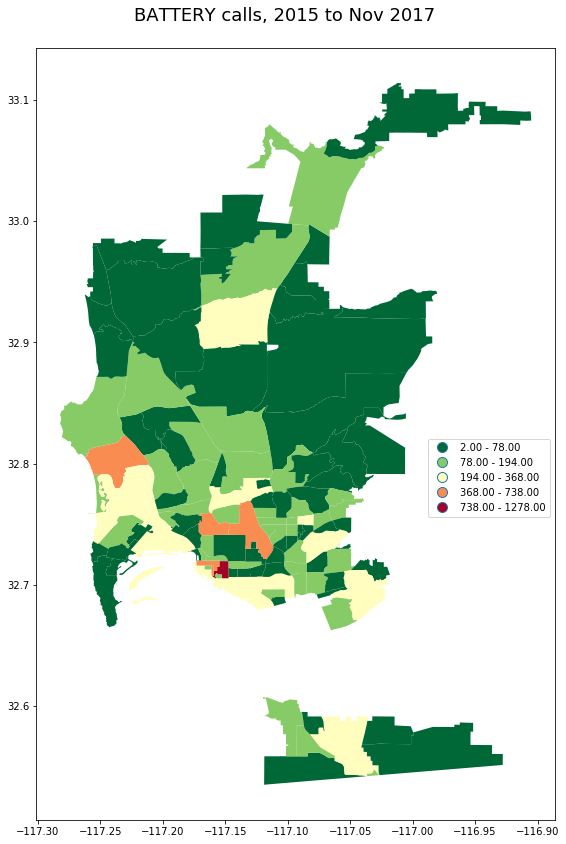

In [16]:
_ = gpd.GeoDataFrame(pd_calls[pd_calls.call_type_desc == 'BATTERY']
                             .groupby('beat')
                             .incident_num.count().to_frame()\
                             .join(beats))

plot_geo(_, 'incident_num', "BATTERY calls, 2015 to Nov 2017")  

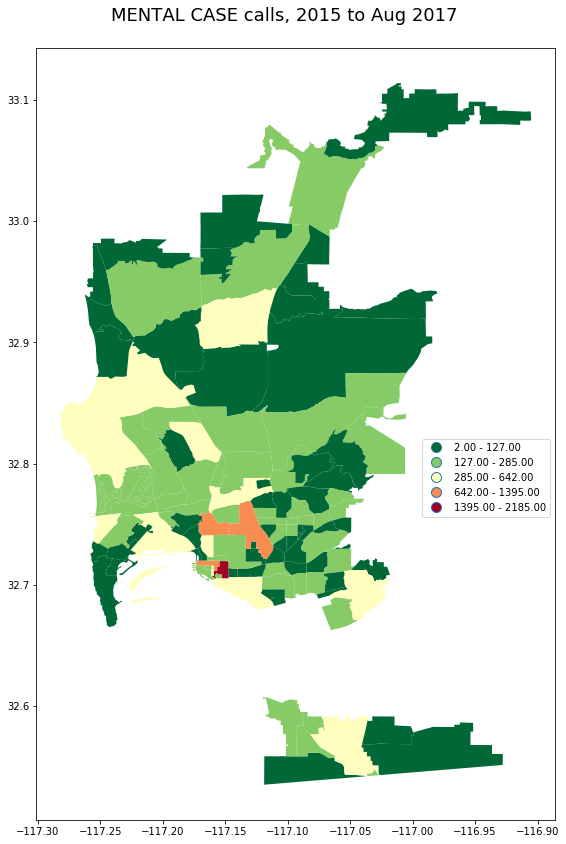

In [17]:
_ = gpd.GeoDataFrame(pd_calls[pd_calls.call_type_desc == 'MENTAL CASE']
                             .groupby('beat')
                             .incident_num.count().to_frame()\
                             .join(beats))

plot_geo(_, 'incident_num', "MENTAL CASE calls, 2015 to Aug 2017")  

# Rhythm Maps

By plotting two time dimensions in a heat map we can often see interesting patterns. 

Here we'll look at the rhythm of parties in Pacific Beach, plotting the number of party calls as colors in a maps with an X axis of the day of the week, and a Y axis of the hour of the day. As you'd expect, the LOUD PARTY calls are primarily on Friday and Saturday nights. 


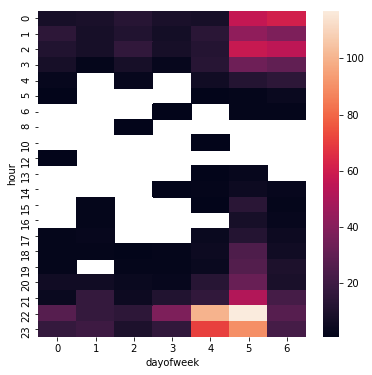

In [18]:
pb_beat = beats[beats.name=='PACIFIC BEACH'].index.values[0]

_ = pd_calls[(pd_calls.call_type_desc=='LOUD PARTY') & (pd_calls.beat == pb_beat)]

ht = pd.pivot_table(data=_, 
                    values='incident_num', index=['hour'],columns=['dayofweek'],
                    aggfunc='count')

fig, ax = plt.subplots(figsize=(6,6))

sns.heatmap(ht, ax=ax);

Looking at the hour of day versus month, there is a clear seasonal pattern, with fewer loud party calls during the winter. 

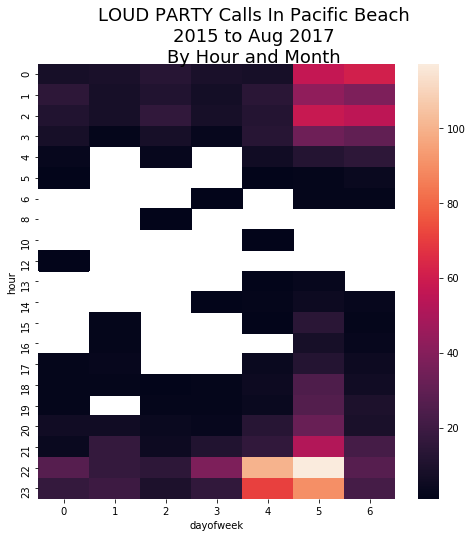

In [19]:
pb_beat = beats[beats.name=='PACIFIC BEACH'].index.values[0]

_ = pd_calls[(pd_calls.call_type_desc=='LOUD PARTY') & (pd_calls.beat == pb_beat)]



fig, ax = plt.subplots(figsize=(8,8))

fig.suptitle("LOUD PARTY Calls In Pacific Beach\n2015 to Aug 2017\nBy Hour and Month", fontsize=18);

sns.heatmap(ht, ax=ax);

In [20]:
hm_beats = pd_calls[['beat_name', 'hour','month']].copy()
hm_beats['count'] = 1
hm_beats = hm_beats.groupby(['beat_name', 'hour','month']).count().reset_index()

# Small Multiple Rhythm Maps

Rhythm maps really shine when they are part of a small multiple grid, or in Seaborn terminology, a Facet Grid. These take a bit more work to setup, but they are really valuable for finding patterns. 

Note how clearly you can see when students go back to school, and the July rowdiness in PB and MB. 

But, the really interesting thing is that in many communities, most obviously in San Ysidro, Core-Columbia, Otay Mesa, and a few others, there are a high number of calls are 4:00 in the afternoon. Any ideas?

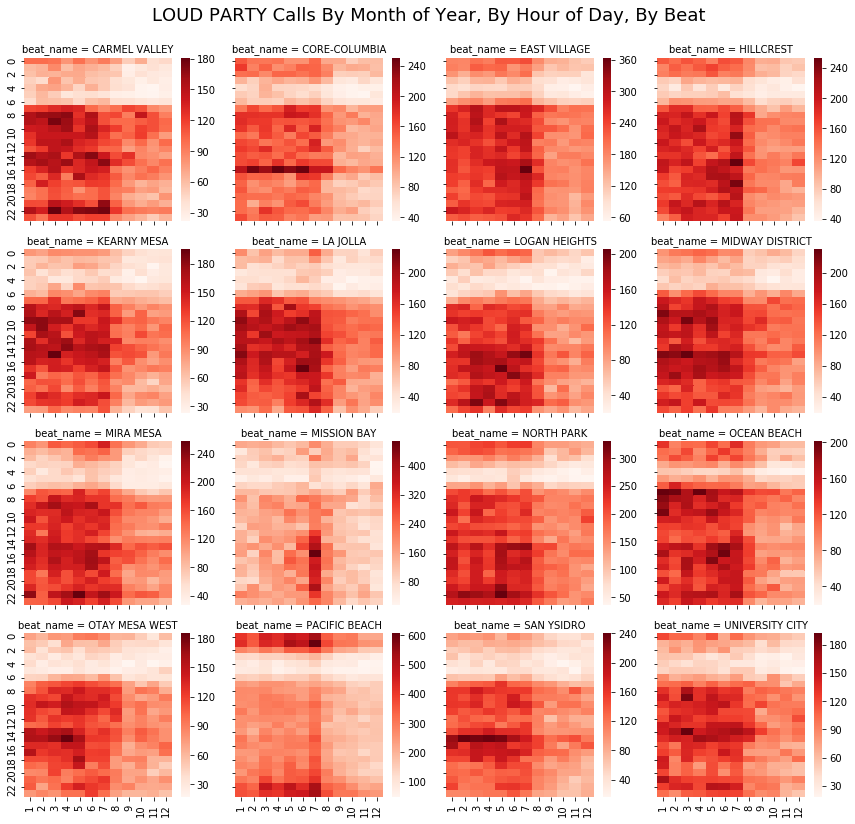

In [21]:

# Top 16 beats
top_beats= pd_calls.beat_name.value_counts().index.values[:16]

from IPython.display import display

# select only the rows for the top 16 beats
_ = hm_beats[hm_beats.beat_name.isin(top_beats)]

g = sns.FacetGrid(_, col="beat_name", col_wrap=4)

def facet_heatmap(data,  color, **kwargs):

    ht = data.pivot(index="hour", columns='month', values='count')

    sns.heatmap(ht, cmap='Reds', **kwargs)  

#cbar_ax = g.fig.add_axes([.92, .3, .02, .4])  # Create a colorbar axes

    
with sns.plotting_context(font_scale=3.5):   
    g = g.map_dataframe(facet_heatmap) 
    
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
g.fig.suptitle("LOUD PARTY Calls By Month of Year, By Hour of Day, By Beat",
              fontsize=18);